In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from datetime import timedelta
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import seaborn as sns
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Load your dataset
df = pd.read_csv("dataset.csv")

df = df.replace({True: 1, False: 0})

df['Ping_Date'] = pd.to_datetime(df['Ping_Date'], format='%Y-%m-%d')

In [2]:
df.head()

StationID                  Station_Name  \
0  0124a793-6b67-4690-8348-54666a807fe7  SRI VARU CELESTIAL APARTMENT   
1  0124a793-6b67-4690-8348-54666a807fe7  SRI VARU CELESTIAL APARTMENT   
2  0124a793-6b67-4690-8348-54666a807fe7  SRI VARU CELESTIAL APARTMENT   
3  0124a793-6b67-4690-8348-54666a807fe7  SRI VARU CELESTIAL APARTMENT   
4  0124a793-6b67-4690-8348-54666a807fe7  SRI VARU CELESTIAL APARTMENT   

  Station_Type Station_Category Station_Access              ChargerID  \
0  RESIDENTIAL            SMALL         PUBLIC  WA000822LAC1S009464-1   
1  RESIDENTIAL            SMALL         PUBLIC  WA000822LAC1S009464-1   
2  RESIDENTIAL            SMALL         PUBLIC  WA000822LAC1S009464-1   
3  RESIDENTIAL            SMALL         PUBLIC  WA000822LAC1S009464-1   
4  RESIDENTIAL            SMALL         PUBLIC  WA000822LAC1S009464-1   

   Ping_Date  hour0  hour1  hour2  ...  hour14  hour15  hour16  hour17  \
0 2023-11-25      1      1      1  ...       1       1       1     1.0   
1 2023-11-26      1      1      1  ...       0       0       0     0.0   
2 2023-11-27      1      1      1  ...       1       1       1     1.0   
3 2023-11-28      1      1      1  ...       1       1       1     1.0   
4 2023-11-29      1      1      1  ...       1       1       1     1.0   

   hour18  hour19  hour20  hour21  hour22  hour23  
0     1.0     1.0     1.0     1.0     1.0     1.0  
1     0.0     0.0     1.0     1.0     1.0     1.0  
2     1.0     1.0     1.0     1.0     1.0     1.0  
3     1.0     1.0     1.0     1.0     1.0     1.0  
4     1.0     1.0     1.0     1.0     1.0     1.0  

[5 rows x 31 columns]

In [3]:
# Display basic information about the dataset
print(df.info())

# Display summary statistics
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22530 entries, 0 to 22529
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   StationID         22530 non-null  object        
 1   Station_Name      22530 non-null  object        
 2   Station_Type      22530 non-null  object        
 3   Station_Category  22530 non-null  object        
 4   Station_Access    22530 non-null  object        
 5   ChargerID         22530 non-null  object        
 6   Ping_Date         22530 non-null  datetime64[ns]
 7   hour0             22530 non-null  int64         
 8   hour1             22530 non-null  int64         
 9   hour2             22530 non-null  int64         
 10  hour3             22530 non-null  int64         
 11  hour4             22530 non-null  int64         
 12  hour5             22530 non-null  int64         
 13  hour6             22530 non-null  int64         
 14  hour7             2253

In [4]:
# Remove rows with null values
df = df.dropna()

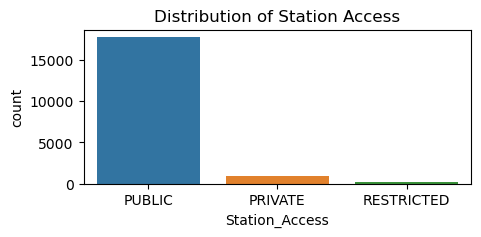

In [5]:
# Visualize the distribution of categorical variables
plt.figure(figsize=(5, 2))
sns.countplot(x='Station_Access', data=df)
plt.title('Distribution of Station Access')
plt.show()

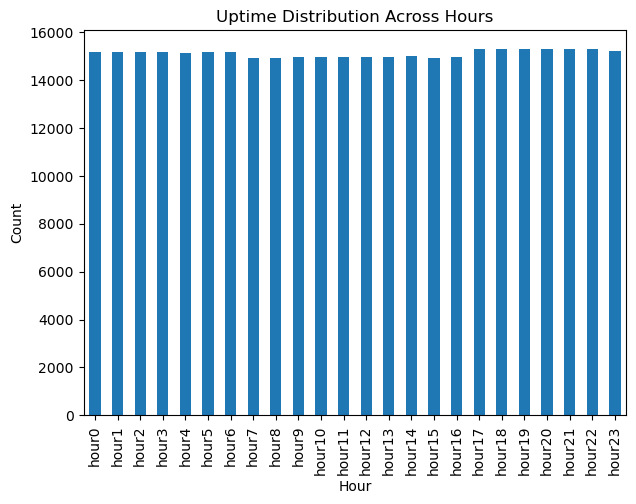

In [6]:
# Visualize uptime distribution across hours
uptime_columns = df.columns[7:]
plt.figure(figsize=(7, 5))
df[uptime_columns].sum().plot(kind='bar')
plt.title('Uptime Distribution Across Hours')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

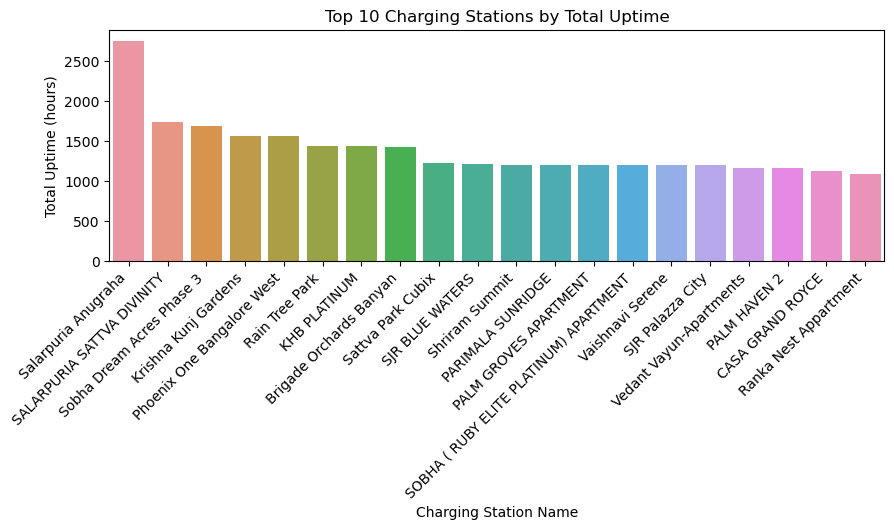

In [7]:
# Extract uptime columns
uptime_columns = [col for col in df.columns if col.startswith('hour')]

# Calculate total uptime for each station
df['Total_Uptime'] = df[uptime_columns].sum(axis=1)

total_uptime_per_station = df.groupby('Station_Name')['Total_Uptime'].sum().reset_index()

# Sort the DataFrame by Total_Uptime in descending order
total_uptime_per_station = total_uptime_per_station.sort_values(by='Total_Uptime', ascending=False)

# Select the top 10 stations
top_10_stations = total_uptime_per_station.head(20)

# Create a bar plot to visualize total uptime for each charging station
plt.figure(figsize=(10, 3))
sns.barplot(x='Station_Name', y='Total_Uptime', data=top_10_stations)
plt.title('Top 10 Charging Stations by Total Uptime')
plt.xlabel('Charging Station Name')
plt.ylabel('Total Uptime (hours)')
plt.xticks(rotation=45, ha='right')
plt.show()

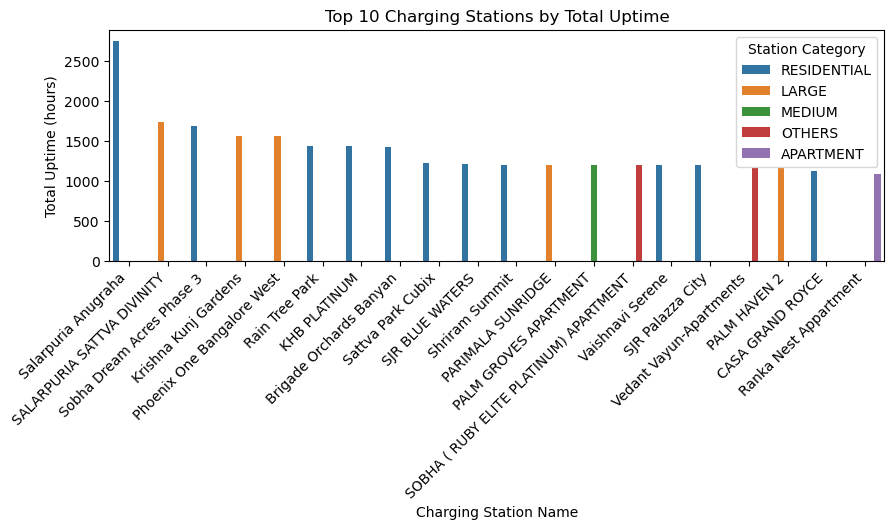

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame
# Extract uptime columns
uptime_columns = [col for col in df.columns if col.startswith('hour')]

# Calculate total uptime for each station
df['Total_Uptime'] = df[uptime_columns].sum(axis=1)

# Group by 'Station_Name' and calculate total uptime
total_uptime_per_station = df.groupby('Station_Name')['Total_Uptime'].sum().reset_index()

# Sort the DataFrame by Total_Uptime in descending order
total_uptime_per_station = total_uptime_per_station.sort_values(by='Total_Uptime', ascending=False)

# Select the top 10 stations
top_10_stations = total_uptime_per_station.head(20)

# Merge with the original DataFrame to get station category
top_10_stations_with_category = pd.merge(top_10_stations, df[['Station_Name', 'Station_Category']], on='Station_Name')

# Create a bar plot to visualize total uptime for each charging station
plt.figure(figsize=(10, 3))
sns.barplot(x='Station_Name', y='Total_Uptime', hue='Station_Category', data=top_10_stations_with_category)
plt.title('Top 10 Charging Stations by Total Uptime')
plt.xlabel('Charging Station Name')
plt.ylabel('Total Uptime (hours)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Station Category')
plt.show()

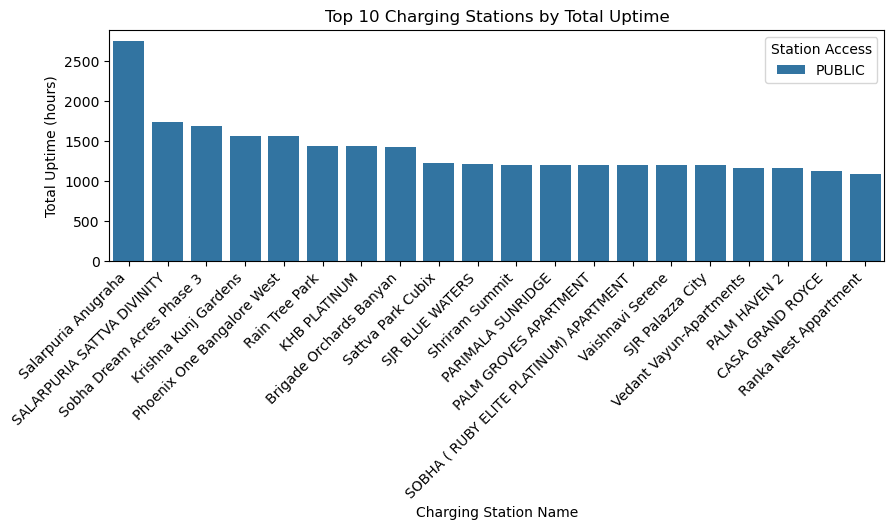

In [9]:
# Assuming 'df' is your DataFrame
# Extract uptime columns
uptime_columns = [col for col in df.columns if col.startswith('hour')]

# Calculate total uptime for each station
df['Total_Uptime'] = df[uptime_columns].sum(axis=1)

# Group by 'Station_Name' and calculate total uptime
total_uptime_per_station = df.groupby('Station_Name')['Total_Uptime'].sum().reset_index()

# Sort the DataFrame by Total_Uptime in descending order
total_uptime_per_station = total_uptime_per_station.sort_values(by='Total_Uptime', ascending=False)

# Select the top 10 stations
top_10_stations = total_uptime_per_station.head(20)

# Merge with the original DataFrame to get station access information
top_10_stations_with_access = pd.merge(top_10_stations, df[['Station_Name', 'Station_Access']], on='Station_Name')

# Create a bar plot to visualize total uptime for each charging station
plt.figure(figsize=(10, 3))
sns.barplot(x='Station_Name', y='Total_Uptime', hue='Station_Access', data=top_10_stations_with_access)
plt.title('Top 10 Charging Stations by Total Uptime')
plt.xlabel('Charging Station Name')
plt.ylabel('Total Uptime (hours)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Station Access')
plt.show()

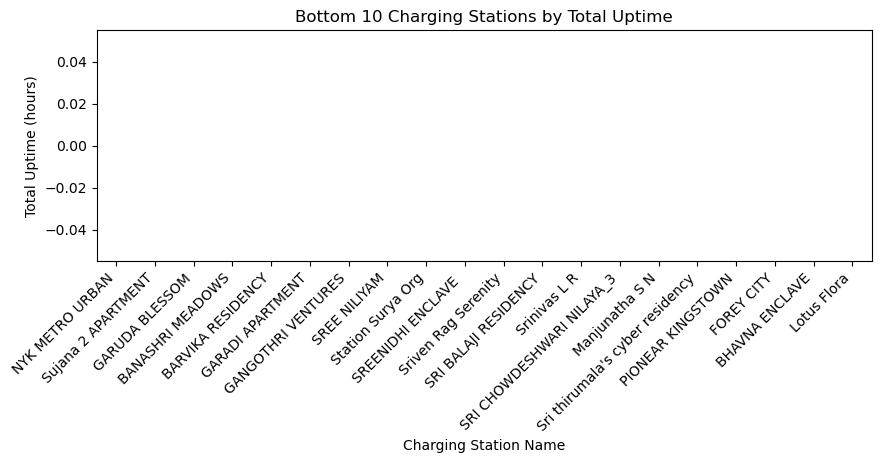

In [10]:
# Extract uptime columns
uptime_columns = [col for col in df.columns if col.startswith('hour')]

# Calculate total uptime for each station
df['Total_Uptime'] = df[uptime_columns].sum(axis=1)

total_uptime_per_station = df.groupby('Station_Name')['Total_Uptime'].sum().reset_index()

# Sort the DataFrame by Total_Uptime in descending order
total_uptime_per_station = total_uptime_per_station.sort_values(by='Total_Uptime', ascending=True)

# Select the top 10 stations
bottom_10_stations = total_uptime_per_station.head(20)

# Create a bar plot to visualize total uptime for each charging station
plt.figure(figsize=(10, 3))
sns.barplot(x='Station_Name', y='Total_Uptime', data=bottom_10_stations)
plt.title('Bottom 10 Charging Stations by Total Uptime')
plt.xlabel('Charging Station Name')
plt.ylabel('Total Uptime (hours)')
plt.xticks(rotation=45, ha='right')
plt.show()

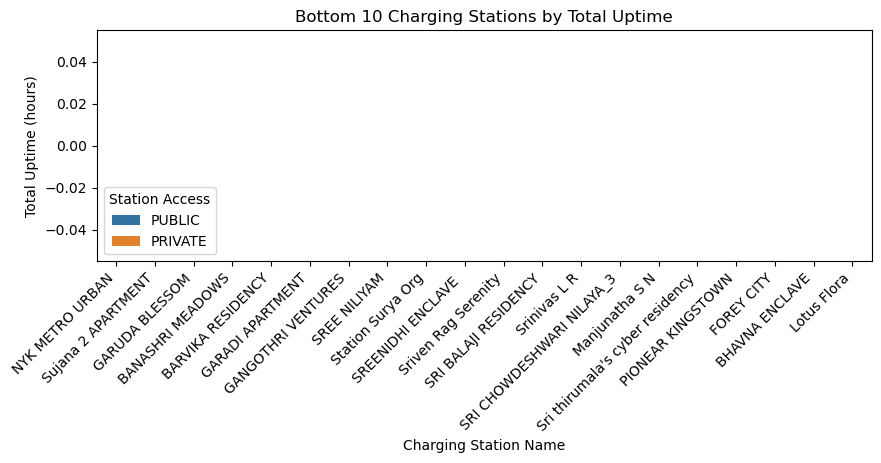

In [11]:
# Assuming 'df' is your DataFrame
# Extract uptime columns
uptime_columns = [col for col in df.columns if col.startswith('hour')]

# Calculate total uptime for each station
df['Total_Uptime'] = df[uptime_columns].sum(axis=1)

# Group by 'Station_Name' and calculate total uptime
total_uptime_per_station = df.groupby('Station_Name')['Total_Uptime'].sum().reset_index()

# Sort the DataFrame by Total_Uptime in descending order
total_uptime_per_station = total_uptime_per_station.sort_values(by='Total_Uptime', ascending=True)

# Select the top 10 stations
bottom_10_stations = total_uptime_per_station.head(20)

# Merge with the original DataFrame to get station access information
bottom_10_stations_with_access = pd.merge(bottom_10_stations, df[['Station_Name', 'Station_Access']], on='Station_Name')

# Create a bar plot to visualize total uptime for each charging station
plt.figure(figsize=(10, 3))
sns.barplot(x='Station_Name', y='Total_Uptime', hue='Station_Access', data=bottom_10_stations_with_access)
plt.title('Bottom 10 Charging Stations by Total Uptime')
plt.xlabel('Charging Station Name')
plt.ylabel('Total Uptime (hours)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Station Access')
plt.show()

# Q1.

Daily Uptime:
Ping_Date
2023-11-25    72627.0
2023-11-26    72748.0
2023-11-27    72816.0
2023-11-28    72540.0
2023-11-29    72237.0
dtype: float64

Hourly Uptime:
hour0     15199.0
hour1     15198.0
hour2     15172.0
hour3     15161.0
hour4     15155.0
hour5     15160.0
hour6     15177.0
hour7     14935.0
hour8     14948.0
hour9     14966.0
hour10    14959.0
hour11    14985.0
hour12    14972.0
hour13    14986.0
hour14    14993.0
hour15    14931.0
hour16    14967.0
hour17    15287.0
hour18    15324.0
hour19    15314.0
hour20    15323.0
hour21    15315.0
hour22    15300.0
hour23    15241.0
dtype: float64


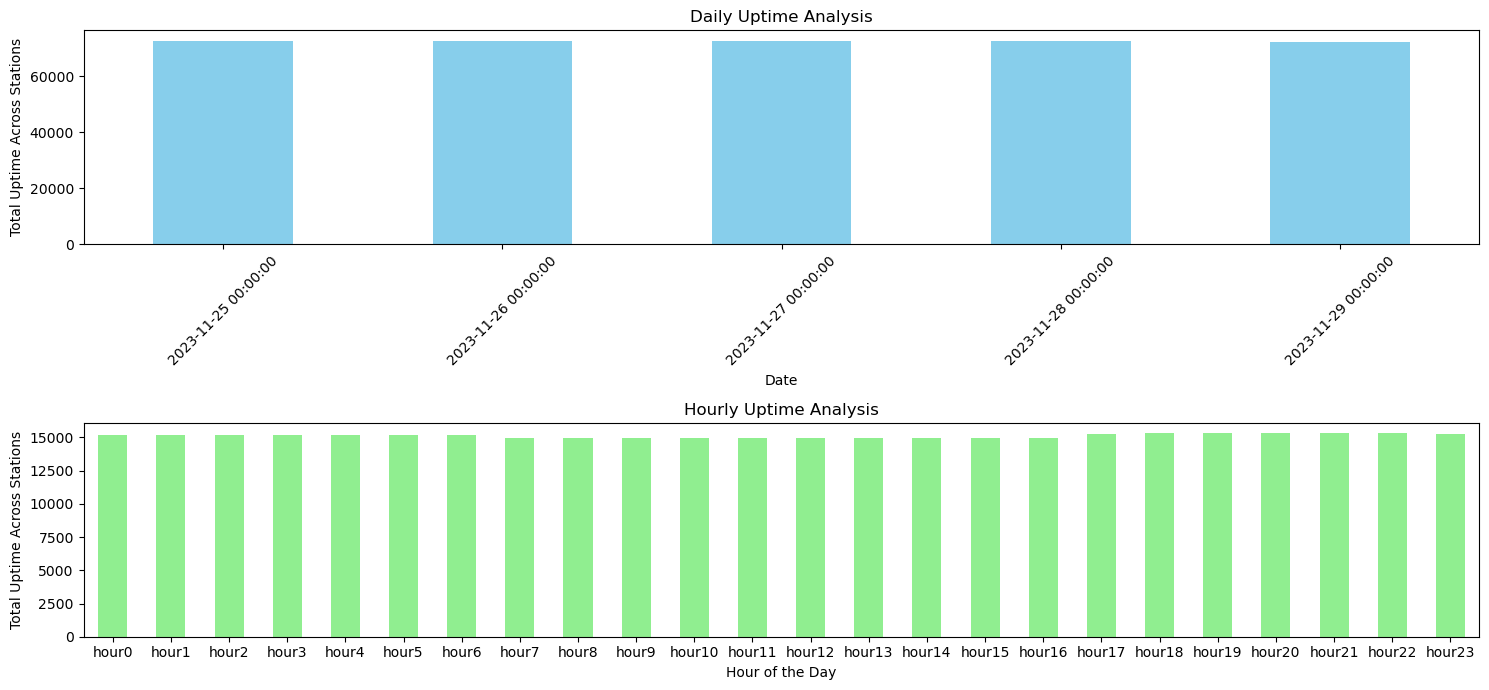

In [12]:
# Convert 'Ping_Date' to datetime type

uptime_columns = [col for col in df.columns if col.startswith('hour')]

# Daily Uptime Analysis
daily_uptime = df.groupby('Ping_Date')[uptime_columns].sum().sum(axis=1)

# Hourly Uptime Analysis
hourly_uptime = df[uptime_columns].sum()

# Display the mean uptime for each date
print("Daily Uptime:")
print(daily_uptime)

# Display the mean uptime for each hour
print("\nHourly Uptime:")
print(hourly_uptime)

# Plotting the results
plt.figure(figsize=(15, 7))

# Plot Daily Uptime
plt.subplot(2, 1, 1)
daily_uptime.plot(kind="bar", title="Daily Uptime Analysis", color='skyblue')
plt.xlabel('Date')
plt.ylabel('Total Uptime Across Stations')
plt.xticks(rotation=45)

# Plot Hourly Uptime
plt.subplot(2, 1, 2)
hourly_uptime.plot(kind="bar", title="Hourly Uptime Analysis", color='lightgreen')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Uptime Across Stations')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


# Q2.

In [13]:
# Extract uptime columns
uptime_columns = [col for col in df.columns if col.startswith('hour')]

# Calculate total uptime for each station
df['Total_Uptime'] = df[uptime_columns].sum(axis=1)

# Display the total uptime for each station in descending order
total_uptime_per_station = df.groupby('Station_Name')['Total_Uptime'].sum().reset_index()
total_uptime_per_station = total_uptime_per_station.sort_values(by='Total_Uptime', ascending=False)

# Display the DataFrame with Station_Name and Total_Uptime
print(total_uptime_per_station[['Station_Name', 'Total_Uptime']])

                    Station_Name  Total_Uptime
1573         Salarpuria Anugraha        2748.0
1238  SALARPURIA SATTVA DIVINITY        1736.0
1645   Sobha Dream Acres Phase 3        1680.0
688         Krishna Kunj Gardens        1562.0
1034  Phoenix One Bangalore West        1555.0
...                          ...           ...
1088                RAHOOL HOMES           0.0
557                         IRIS           0.0
894              NYK METRO URBAN           0.0
220       BSR MANTRALAYA PHASE 2           0.0
1255         SAPTAGIRI RESIDENCY           0.0

[1892 rows x 2 columns]


# Q3.

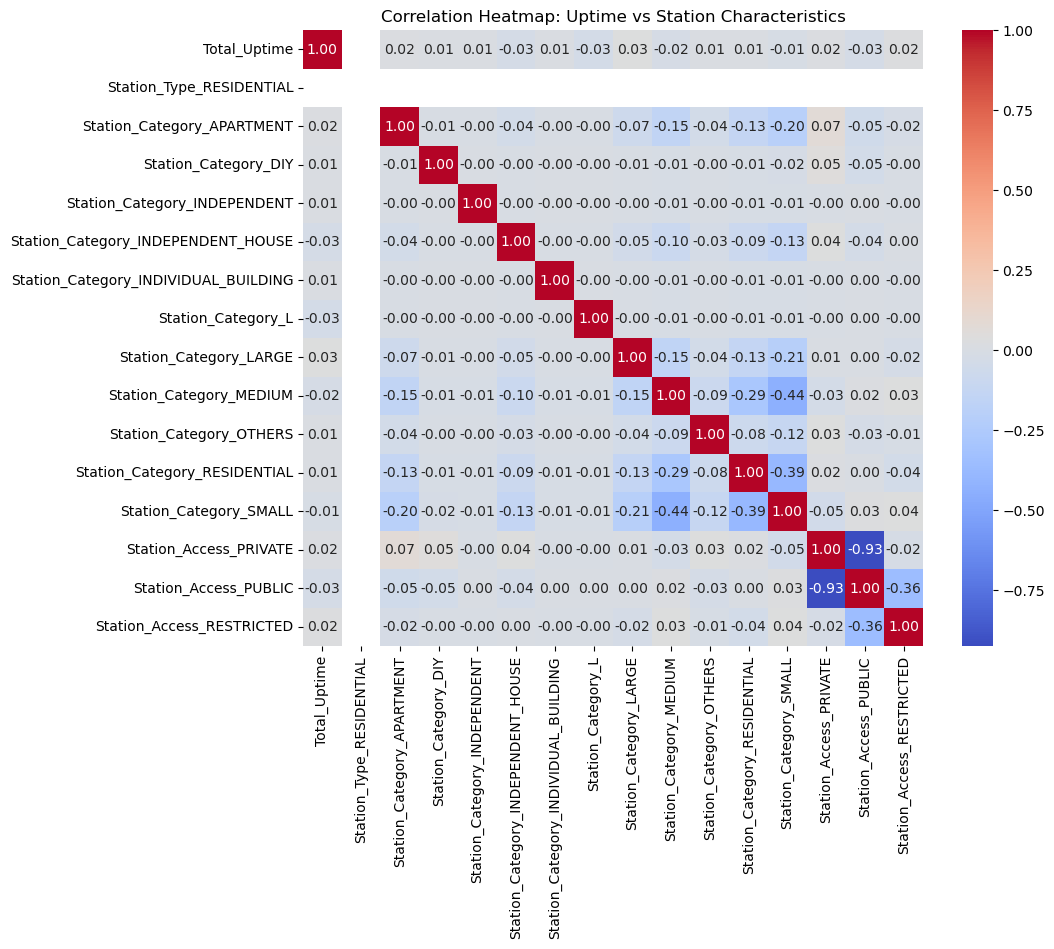

In [14]:
# Extract uptime columns
uptime_columns = [col for col in df.columns if col.startswith('hour')]

# Calculate total uptime for each station
df['Total_Uptime'] = df[uptime_columns].sum(axis=1)

# Analyze correlation with station characteristics
characteristics_columns = ['Station_Type', 'Station_Category', 'Station_Access']

# Create a DataFrame with relevant columns
correlation_data = df[characteristics_columns + ['Total_Uptime']]

# Convert categorical columns to numerical using one-hot encoding
correlation_data = pd.get_dummies(correlation_data)

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: Uptime vs Station Characteristics')
plt.show()

# Q4.

In [15]:
# Assuming 'df' is your DataFrame and 'selected_charger_station' is the chosen ChargerID
selected_charger_station = 'WA000522LAC1S000865-1'

# Convert 'Ping_Date' to datetime type
df['Ping_Date'] = pd.to_datetime(df['Ping_Date'], format='%d-%m-%Y')

# Extract uptime columns
uptime_columns = [col for col in df.columns if col.startswith('hour')]

# Calculate total uptime for each station
df['Total_Uptime'] = df[uptime_columns].sum(axis=1)

# Filter data for the selected charger station
charger_data = df[df['ChargerID'] == selected_charger_station]

# Group by date and calculate daily total uptime
daily_uptime = charger_data.groupby('Ping_Date')['Total_Uptime'].sum().reset_index()

# Set 'Ping_Date' as the index
daily_uptime.set_index('Ping_Date', inplace=True)

# Split the data into training and testing sets
train_size = int(len(daily_uptime) * 0.8)
train, test = daily_uptime[0:train_size], daily_uptime[train_size:]

# Define the range of values for p, d, and q
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

# Generate all possible combinations of p, d, and q
parameter_combinations = list(itertools.product(p_values, d_values, q_values))

# Initialize variables to store the best parameters and MAE
best_mae = float('inf')
best_params = None

# Iterate through all combinations and evaluate model performance
for params in parameter_combinations:
    try:
        model = ARIMA(train, order=params)
        model_fit = model.fit()

        # Forecast future uptimes (next day)
        forecast_steps = len(test)
        forecast = model_fit.get_forecast(steps=forecast_steps)

        # Calculate Mean Absolute Error (MAE)
        y_true = test['Total_Uptime']
        y_pred = forecast.predicted_mean
        mae = mean_absolute_error(y_true, y_pred)

        # Update best parameters if the current combination is better
        if mae < best_mae:
            best_mae = mae
            best_params = params

    except:
        continue

# Display the best parameters
print("Best Parameters:", best_params)

# Fit the model with the best parameters
best_model = ARIMA(daily_uptime, order=best_params)
best_model_fit = best_model.fit()

# Forecast future uptimes (next day)
forecast_steps = 1
forecast = best_model_fit.get_forecast(steps=forecast_steps)

# Display the forecast
forecast_index = pd.date_range(daily_uptime.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_next_day = pd.DataFrame({'Forecast_Uptime': forecast.predicted_mean}, index=forecast_index)
print("Forecasted Uptime for the Next Day:", forecast_next_day['Forecast_Uptime'][0])

# Ensure equal lengths for y_true and y_pred
y_true = daily_uptime['Total_Uptime'].values
y_pred = forecast_next_day['Forecast_Uptime'].values

# Trim y_true if lengths are not equal
if len(y_true) > len(y_pred):
    y_true = y_true[:len(y_pred)]

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Display additional metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Best Parameters: (0, 1, 0)
Forecasted Uptime for the Next Day: 24.0
Mean Absolute Error (MAE): 0.0
Mean Squared Error (MSE): 0.0
Root Mean Squared Error (RMSE): 0.0


In [16]:
# Assuming 'df' is your DataFrame and 'selected_charger_station' is the chosen ChargerID
selected_charger_station = 'WA000822LAC1S005336-1'

# Convert 'Ping_Date' to datetime type
df['Ping_Date'] = pd.to_datetime(df['Ping_Date'], format='%d-%m-%Y')

# Extract uptime columns
uptime_columns = [col for col in df.columns if col.startswith('hour')]

# Calculate total uptime for each station
df['Total_Uptime'] = df[uptime_columns].sum(axis=1)

# Filter data for the selected charger station
charger_data = df[df['ChargerID'] == selected_charger_station]

# Group by date and calculate daily total uptime
daily_uptime = charger_data.groupby('Ping_Date')['Total_Uptime'].sum().reset_index()

# Set 'Ping_Date' as the index
daily_uptime.set_index('Ping_Date', inplace=True)

# Split the data into training and testing sets
train_size = int(len(daily_uptime) * 0.8)
train, test = daily_uptime[0:train_size], daily_uptime[train_size:]

# Define the SARIMA model with potentially simpler parameters
order = (1, 0, 1)
seasonal_order = (1, 0, 1, 7)  # Assuming a weekly seasonality, adjust as needed
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)

# Fit the model
model_fit = model.fit()

# Forecast future uptimes (next day)
forecast_steps = 1  # Adjust the forecast length as needed
forecast = model_fit.get_forecast(steps=forecast_steps)

# Get the forecasted mean for the next day
forecast_next_day = forecast.predicted_mean.values[0]
print("Forecasted Uptime for the Next Day:", forecast_next_day)

# Calculate metrics
y_true = test['Total_Uptime']
y_pred = forecast.predicted_mean
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Display the metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Forecasted Uptime for the Next Day: 23.99997580796956
Mean Absolute Error (MAE): 2.4192030441128054e-05
Mean Squared Error (MSE): 5.852543368644664e-10
Root Mean Squared Error (RMSE): 2.4192030441128054e-05


In [17]:
# Assuming 'df' is your DataFrame and 'selected_charger_station' is the chosen ChargerID
selected_charger_station = 'WA000522LAC1S000865-1'

# Convert 'Ping_Date' to datetime type
df['Ping_Date'] = pd.to_datetime(df['Ping_Date'], format='%d-%m-%Y')

# Extract uptime columns
uptime_columns = [col for col in df.columns if col.startswith('hour')]

# Calculate total uptime for each station
df['Total_Uptime'] = df[uptime_columns].sum(axis=1)

# Filter data for the selected charger station
charger_data = df[df['ChargerID'] == selected_charger_station]

# Group by date and calculate daily total uptime
daily_uptime = charger_data.groupby('Ping_Date')['Total_Uptime'].sum().reset_index()

# Set 'Ping_Date' as the index
daily_uptime.set_index('Ping_Date', inplace=True)

# Split the data into training and testing sets
train_size = int(len(daily_uptime) * 0.8)
train, test = daily_uptime[0:train_size], daily_uptime[train_size:]

# Specify initial seasonal component values
initial_seasonal = train.groupby(train.index.dayofweek)['Total_Uptime'].mean()

# Repeat the initial seasonal values to match the seasonal frequency
initial_seasonal = initial_seasonal.reindex(range(7)).ffill()

# Specify initial level
initial_level = train['Total_Uptime'].iloc[0]

# Define the Seasonal ETS model with initial seasonal and level components
seasonal_ets_model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=7, initialization_method='known', initial_seasonal=initial_seasonal, initial_level=initial_level)

# Fit the model
seasonal_ets_model_fit = seasonal_ets_model.fit()

# Forecast future uptimes (next day)
forecast_steps = len(test)
forecast = seasonal_ets_model_fit.forecast(steps=forecast_steps)

# Calculate metrics
y_true = test['Total_Uptime']
y_pred = forecast
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Forecast future uptimes (next day)
forecast_next_day = seasonal_ets_model_fit.forecast(steps=1)
print("Forecasted Uptime for the Next Day:", forecast_next_day.values[0])

# Display the metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Forecasted Uptime for the Next Day: 24.0
Mean Absolute Error (MAE): 0.0
Mean Squared Error (MSE): 0.0
Root Mean Squared Error (RMSE): 0.0


# Q5.

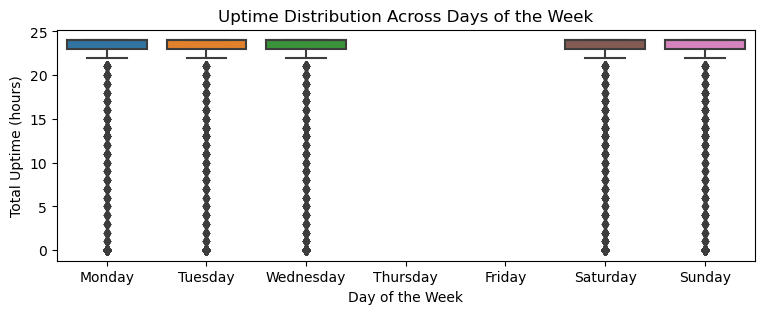

In [18]:
# Extract uptime columns
uptime_columns = [col for col in df.columns if col.startswith('hour')]

# Calculate total uptime for each station
df['Total_Uptime'] = df[uptime_columns].sum(axis=1)

# Extract day of the week
df['Day_of_Week'] = df['Ping_Date'].dt.day_name()

# Analyze uptimes based on the day of the week
plt.figure(figsize=(9, 3))
sns.boxplot(x='Day_of_Week', y='Total_Uptime', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Uptime Distribution Across Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Uptime (hours)')
plt.show()


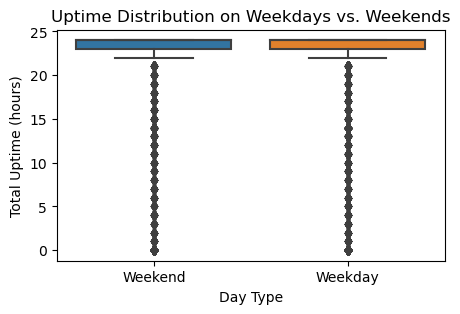

In [19]:
# Extract uptime columns
uptime_columns = [col for col in df.columns if col.startswith('hour')]

# Calculate total uptime for each station
df['Total_Uptime'] = df[uptime_columns].sum(axis=1)

# Extract day of the week
df['Day_of_Week'] = df['Ping_Date'].dt.day_name()

# Create a new variable indicating whether a day is a weekday or weekend
df['Weekday_Or_Weekend'] = df['Day_of_Week'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# Analyze uptimes based on weekdays and weekends
plt.figure(figsize=(5, 3))
sns.boxplot(x='Weekday_Or_Weekend', y='Total_Uptime', data=df)
plt.title('Uptime Distribution on Weekdays vs. Weekends')
plt.xlabel('Day Type')
plt.ylabel('Total Uptime (hours)')
plt.show()

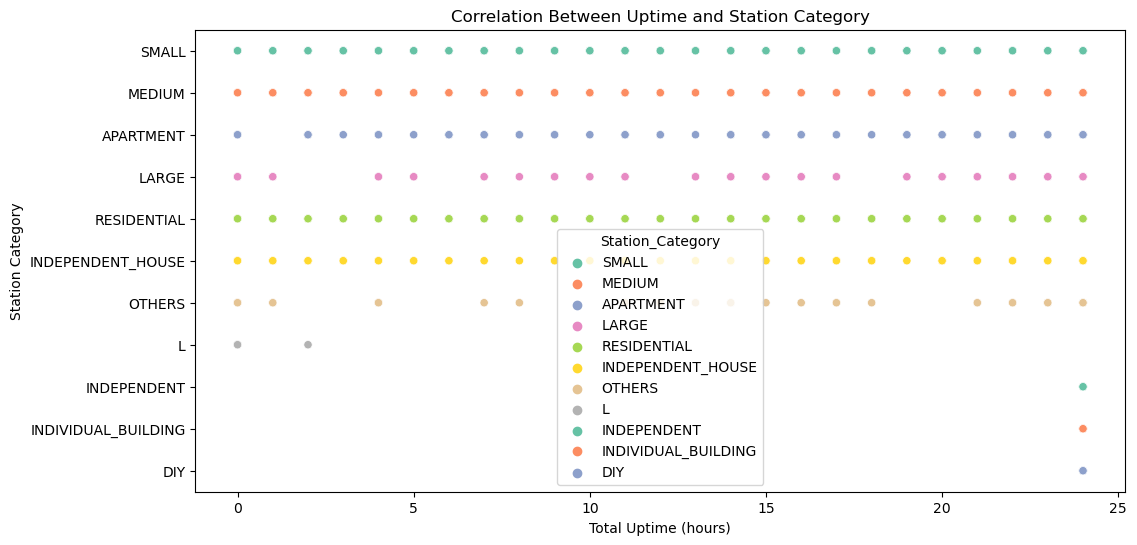

In [20]:
# Extract uptime columns
uptime_columns = [col for col in df.columns if col.startswith('hour')]

# Calculate total uptime for each station
df['Total_Uptime'] = df[uptime_columns].sum(axis=1)

# Analyze correlation between uptime and station category
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Total_Uptime', y='Station_Category', data=df, hue='Station_Category', palette='Set2')
plt.title('Correlation Between Uptime and Station Category')
plt.xlabel('Total Uptime (hours)')
plt.ylabel('Station Category')
plt.show()

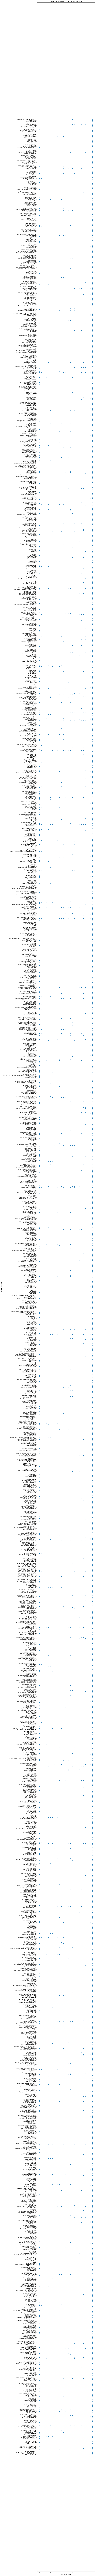

In [21]:
# Extract uptime columns
uptime_columns = [col for col in df.columns if col.startswith('hour')]

# Calculate total uptime for each station
df['Total_Uptime'] = df[uptime_columns].sum(axis=1)

# Analyze correlation between uptime and station category
plt.figure(figsize=(9, 400))
sns.scatterplot(x='Total_Uptime', y='Station_Name', data=df, palette='Set2')
plt.title('Correlation Between Uptime and Station Name')
plt.xlabel('Total Uptime (hours)')
plt.ylabel('Station Category')
plt.show()